# Interatomic force field (IFF) optimization for W-based metal alloys

## Processing VASP output data into pickled dictionaries

Author: Lukas Vlcek

Start Date: 2018-04-22

In [7]:
from datetime import datetime ; print('Last update:', datetime.now())

Last update: 2018-09-15 00:17:03.453814


In [8]:
%matplotlib inline
import os
import re
import numpy as np
import pickle
import matplotlib.pyplot as plt

# source of raw data and destination for processed data
target_raw = '../data/target_raw'
target_proc = '../data/target_processed'

**List of target trajectories**

In [9]:
datasets = ['bcc_npt_langevin_300K',
            'fcc_npt_langevin_300K',
            'vac_npt_langevin_2000K',
            'i110_npt_langevin_2000K',
            'i111_npt_langevin_2000K',
            'screw_111_npt_langevin_2000K',
            'bcc_npt_langevin_3700K',
            'liq_3700K',
            'liq_5000K']

with open(os.path.join(target_proc,  "datasets.pickle"), 'wb') as fo:
    pickle.dump(datasets, fo)

print(datasets)

['bcc_npt_langevin_300K', 'fcc_npt_langevin_300K', 'vac_npt_langevin_2000K', 'i110_npt_langevin_2000K', 'i111_npt_langevin_2000K', 'screw_111_npt_langevin_2000K', 'bcc_npt_langevin_3700K', 'liq_3700K', 'liq_5000K']


**For each system, extract configuration, box, and energy from XDATCAR and md.out files**

In [10]:
#%%writefile ../../statmechlib/statmechlib/read_data/read_vasp.py

def read_vasp_md(dataset):
    """
    Reads configuration and energy files from a VASP simulation in a given directory
    and returns trajectory data in a dictionary.
    
    Parameters
    ----------
    dataset : string
              directory with VASP MD simulation data has to contain XDATCAR and md.out files
    Returns
    -------
    traj : dictionary
           trajectory information (configuration, box, energy, forces)
    """
    
    # read configurations (box + particle coordinates)
    with open(os.path.join(dataset, 'XDATCAR'), 'r') as fc:
        xyzs = [] ; boxs = []
        for line in iter(fc.readline, ''):
            line = fc.readline()
            
            # box parameters
            box = np.empty((3, 3), dtype=float)
            for i in range(3):
                box[i,:] = [float(x) for x in re.findall('\S+', fc.readline())]

            # number of atoms
            line = fc.readline()
            nat = int(re.findall('\S+', fc.readline())[0])
            line = fc.readline()
            
            # atomic configuration
            xyz = np.empty((nat, 3), dtype=float)
            for i in range(nat):
                xyz[i] = [float(x) for x in re.findall('\S+', fc.readline())]
            
            boxs.append(box)
            xyzs.append(xyz)
    
    # read configurational energies
    with open(os.path.join(dataset, 'md.out'), 'r') as fe:
        enes = [] ; temps = []
        for line in iter(fe.readline, ''):
            if re.search('T=', line):
                sarr = re.findall('\S+', line)
                temps.append(float(sarr[2]))
                enes.append(float(sarr[8]))
    
    # check if trajectory lists match
    assert len(enes) == len(xyzs), f'{dataset} XYZ and energy lenghts do not match: {len(enes)}, {len(xyzs)}'
    
    # combine trajectory data in a dictionary
    traj = {'box':boxs, 'xyz':xyzs, 'energy':enes, 'forces':[], 'temp':temps}

    return traj

**Read trajectory information**

In [12]:
for dset in datasets:
    # read trajectory information from VASP simulation directory
    traj = read_vasp_md(target_raw + '/' + dset)
    
    # save trajectory data to pickle for later use
    with open(os.path.join(target_proc, dset + ".pickle"), 'wb') as fo:
        pickle.dump(traj, fo)

Define a function for the calculation of the mean squared displacement

In [13]:
def get_msd(xyzs):
    """Return mean squared displacement (msd) for a given trajectory (traj)."""
    msd = []
    for rs in xyzs:
        msd.append(np.mean((rs - xyzs[0])**2))
    #msd = [0.0 for _ in range(len(xyzs))]
    return np.array(msd)

**Check energy, volume, temperature, and MSD for the trajectories**

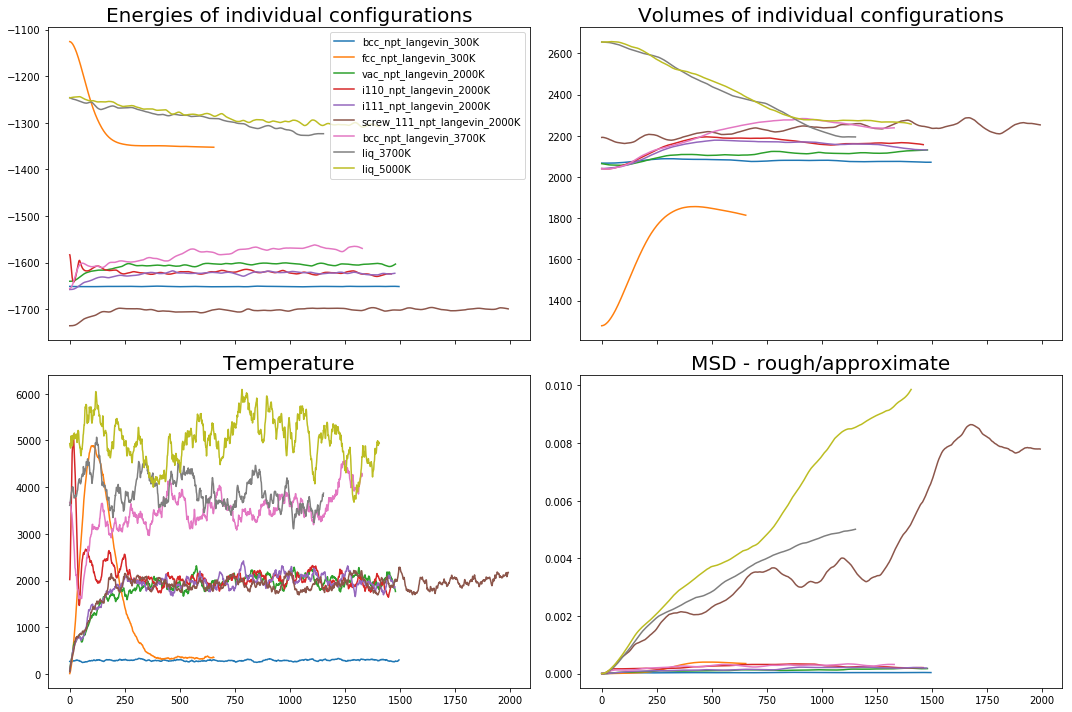

In [14]:
fig, axes = plt.subplots(2, 2, sharex='col', figsize=(15,10))

for dset in datasets:
    with open(os.path.join(target_proc, dset + ".pickle"), 'rb') as fo:
        traj = pickle.load(fo)
        msd = get_msd(traj['xyz'])
        
        #axes[0,0].plot([e/x.shape[0] for e, x in zip(traj['energy'], traj['xyz'])], label=dset)
        axes[0,0].plot([e for e, x in zip(traj['energy'], traj['xyz'])], label=dset)

        axes[0,1].plot([np.linalg.det(b) for b in traj['box']], label=dset)
        axes[1,0].plot([t for t in traj['temp']], label=dset)
        axes[1,1].plot(msd, label=dset)

axes[0,0].legend()
axes[0,0].set_title('Energies of individual configurations', fontsize=20)
axes[0,1].set_title('Volumes of individual configurations', fontsize=20)       
axes[1,0].set_title('Temperature', fontsize=20)
axes[1,1].set_title('MSD - rough/approximate', fontsize=20)
fig.tight_layout()

**Read pickled trajectory and filter samples based on the plots above**

In [27]:
for dset in datasets:
    with open(os.path.join(target_proc, dset + ".pickle"), 'rb') as fo:
        traj = pickle.load(fo)
    
    traj_new = {}
    for key in traj.keys(): 
        traj_new[key] = traj[key][300::10]
        
    # save filtered trajectory data to pickle for later use
    with open(os.path.join(target_proc, dset + "_filtered.pickle"), 'wb') as fo:
        pickle.dump(traj_new, fo)

datasets_filtered = [dat+"_filtered" for dat in datasets]

with open(os.path.join(target_proc,  "datasets_filtered.pickle"), 'wb') as fo:
    pickle.dump(datasets_filtered, fo)

In [3]:
%%writefile -a ../../statmechlib/statmechlib/read_write/read_vasp.py

def read_vasp_0k(dataset):
    """
    Reads configuration and energy files from a VASP energy minimization in a given directory
    and returns trajectory (1 config) data in a dictionary.
    
    Parameters
    ----------
    dataset : string
              directory with VASP MD simulation data has to contain XDATCAR and md.out files
    Returns
    -------
    traj : dictionary
           trajectory information (configuration, box, energy, forces)
    """
    
    # read configurations (box + particle coordinates)
    with open(os.path.join(dataset, 'rlx.CONTCAR'), 'r') as fc:
        xyzs = [] ; boxs = []
        
        line = fc.readline()
        scale = float(re.findall('\S+', fc.readline())[0])
            
        # box parameters
        box = np.empty((3, 3), dtype=float)
        for i in range(3):
            box[i,:] = [float(x)*scale for x in re.findall('\S+', fc.readline())]

        # number of atoms
        line = fc.readline()
        nat = int(re.findall('\S+', fc.readline())[0])
        line = fc.readline()
            
        # atomic configuration
        xyz = np.empty((nat, 3), dtype=float)
        for i in range(nat):
            xyz[i] = [float(x) for x in re.findall('\S+', fc.readline())]
            
        boxs.append(box)
        xyzs.append(xyz)
    
    # read configurational energies
    with open(os.path.join(dataset, 'rlx.md.out'), 'r') as fe:
        enes = [] ; temps = []
        for line in iter(fe.readline, ''):
            if re.search('F=', line):
                sarr = re.findall('\S+', line)
                ene_last = float(sarr[4])
        temps.append(0.0)
        enes.append(ene_last)
        
    # check if trajectory lists match
    assert len(enes) == len(xyzs), f'{dataset} XYZ and energy lenghts do not match: {len(enes)}, {len(xyzs)}'
    
    # combine trajectory data in a dictionary
    traj = {'box':boxs, 'xyz':xyzs, 'energy':enes, 'forces':[], 'temp':temps}

    return traj

Appending to ../../statmechlib/statmechlib/read_write/read_vasp.py


In [2]:
pwd

'/Users/l2v/work/force_fields/eam-models/notebooks'

In [22]:
datasets0 = [#'bcc_npt_langevin_300K',
            'fcc_npt_langevin_300K',
            'vac_npt_langevin_2000K',
            'i110_npt_langevin_2000K',
            'i111_npt_langevin_2000K',
            'screw_111_npt_langevin_2000K']

In [24]:
for dset in datasets0:
    # read trajectory information from VASP simulation directory
    traj = read_vasp_0k(target_raw + '/' + dset)
    print('TRAJ', dset)
    print(traj,'\n')

TRAJ fcc_npt_langevin_300K
{'box': [array([[ 10.85089164,   0.        ,   0.        ],
       [  0.        ,  10.85089164,   0.        ],
       [  0.        ,   0.        ,  10.85089164]])], 'xyz': [array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.16666667,  0.16666667],
       [ 0.16666667,  0.        ,  0.16666667],
       [ 0.16666667,  0.16666667,  0.        ],
       [ 0.        ,  0.        ,  0.33333333],
       [ 0.        ,  0.16666667,  0.5       ],
       [ 0.16666667,  0.        ,  0.5       ],
       [ 0.16666667,  0.16666667,  0.33333333],
       [ 0.        ,  0.        ,  0.66666667],
       [ 0.        ,  0.16666667,  0.83333333],
       [ 0.16666667,  0.        ,  0.83333333],
       [ 0.16666667,  0.16666667,  0.66666667],
       [ 0.        ,  0.33333333,  0.        ],
       [ 0.        ,  0.5       ,  0.16666667],
       [ 0.16666667,  0.33333333,  0.16666667],
       [ 0.16666667,  0.5       ,  0.        ],
       [ 0.        ,  0.33333333